<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/cancer_random_initial_weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cancer_random_initial_weights

> Purpose of this notebook is to explore the case of random initial weights.

In [ ]:
#| default_exp cancer_validation_ensemble

Setup: Surely there is a way to get rid of having to put this cell everywhere. hmmm.

Or we can just copy paste / delete this in and out when needed. Either way, getting close to a decent workable workflow.

In [1]:
#| hide
import os
from google.colab import drive

def colab_is_true():

    try: 
        from google.colab import drive

        return True 
    except ModuleNotFoundError:
        return False

def setup_colab():

    drive.mount('/content/drive',force_remount=True)
    #os.system('unzip -q "/content/drive/My Drive/archive (1).zip"')
    os.system('git clone https://github.com/hamish-haggerty/cancer-proj.git')

    os.chdir('cancer-proj')
    
    os.system('pip install .')
    os.system('pip install -qU nbdev')
    os.system('nbdev_install_quarto')

    os.system('unzip -q "/content/drive/My Drive/archive (1).zip"') #does this work?

if __name__ == "__main__":
    on_colab = colab_is_true()
    if on_colab:
        setup_colab()

Mounted at /content/drive


In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
#| export
from fastai.vision.all import *
from base_rbt.all import *
from cancer_proj.cancer_dataloading import *
from cancer_proj.cancer_metrics import *
from cancer_proj.cancer_maintrain import *

## Load the data

In [4]:
#| hide

#Since we have cloned repository and cd'd into it (and the data itself is not stored in the
#repo) we need cd out of it, get the data, then cd back into the repo `cancer-proj`.
#This is a bit annoying, can maybe remove this later
if on_colab:
    #os.chdir('..') #assumes we are currently in cancer-proj directory
    train_dir = colab_train_dir
    test_dir = colab_test_dir
else:
    train_dir = local_train_dir
    test_dir = local_test_dir

#define general hps
device ='cuda' if torch.cuda.is_available() else 'cpu'
#bs=256
#bs=698
bs=256
bs_tune=256
size=128
bs_val=174

#get the data dictionary
data_dict = get_fnames_dls_dict(train_dir=train_dir,test_dir=test_dir,
                    device=device,bs_val=bs_val,bs=bs,bs_tune=bs_tune,size=size,n_in=3)

#get the dataloaders
dls_train,dls_tune,dls_valid = data_dict['dls_train'],data_dict['dls_tune'],data_dict['dls_valid']
x,y = data_dict['x'],data_dict['y']
xval,yval = data_dict['xval'],data_dict['yval']
xtune,ytune = data_dict['xtune'],data_dict['ytune']
vocab = data_dict['vocab']

#If we want to write some tests (make sure the data is same every time etc):
fnames,fnames_train,fnames_tune,fnames_valid,fnames_test = data_dict['fnames'],data_dict['fnames_train'],data_dict['fnames_tune'],data_dict['fnames_valid'],data_dict['fnames_test']

test_eq(x.shape,xtune.shape)

# if on_colab:
#     os.chdir('cancer-proj')

## Load aug pipelines here

In [5]:
#| hide

aug_dict = create_aug_pipelines(size=size,device=device,Augs=BYOL_Augs,TUNE_Augs=TUNE_Augs,Val_Augs=Val_Augs)
aug_pipelines = aug_dict['aug_pipelines']
aug_pipelines_tune = aug_dict['aug_pipelines_tune']
aug_pipelines_test = aug_dict['aug_pipelines_test'] 

## Optionally, display:

In [ ]:
#| hide
#show_bt_batch(dls=dls_train,aug=aug_pipelines,n_in=3)

In [ ]:
#| hide

#show_linear_batch(dls=dls_tune,n_in=3,aug=aug_pipelines_tune,n=2,print_augs=True)

In [6]:
#| export

@patch
def lf(self:BarlowTwins, pred,*yb): return lf_bt(pred,I=self.I,lmb=self.lmb)

## Note: using this default encoder, for random weights, doesn't seem to work real well.

In [45]:
#| export

# """@patch
# @delegates(Learner.fit_one_cycle)
# def encoder_fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
#               pct_start=0.3, div=5.0, **kwargs):
#     "Fine tuner to use with bt initial weights"
    
#     #self.freeze() #freeze the resnet
#     self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
#     base_lr /= 2
#     #self.unfreeze() #unfreeze the resnet. 
#     #self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
#     self.fit_one_cycle(epochs, slice(base_lr, base_lr), pct_start=pct_start, div=div, **kwargs)

#     self.unfreeze() #We can unfreeze at the end"""

## Note: we don't actually want to freeze the resnet when pretraining in this notebook, since the initial weights are random. So we just need to make sure encoder_fine_tune isn't doing that

## Test: make sure that it freezes the appropriate part of model:

Make sure resnet frozen, linear head unfrozen:

In [7]:
bt_model,encoder = create_model(which_model='bt_pretrain',ps=8192,device=device)
model = LM(encoder)
test_eq(len(my_splitter(model)),2)
test_eq(len(my_splitter_bt(bt_model)),2)

learn = Learner(dls_tune,model,splitter=my_splitter,cbs = [LinearBt(aug_pipelines=aug_pipelines_tune,n_in=3)],wd=0.0)
learn.freeze()
print('body should be frozen, (sans batchnorm) linear head unfrozen')
learn.summary()

Downloading: "https://github.com/facebookresearch/barlowtwins/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://dl.fbaipublicfiles.com/barlowtwins/ep1000_bs2048_lrw0.2_lrb0.0048_lambd0.0051/resnet50.pth" to /root/.cache/torch/hub/checkpoints/resnet50.pth


  0%|          | 0.00/90.0M [00:00<?, ?B/s]

body should be frozen, (sans batchnorm) linear head unfrozen


LM (Input shape: 256 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 64 x 64 x 64  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     256 x 64 x 32 x 32  
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     256 x 256 x 32 x 32 
Conv2d                                    16384      False     
BatchNorm2d                               

## We can use this to check the  bt-model is of the appropriate type: resnet + projector

In [8]:
#| hide

#test : manual. BT

learn = Learner(dls_train,bt_model,splitter=my_splitter_bt,cbs=[BarlowTwins(aug_pipelines,n_in=3,lmb=1/8192,print_augs=False)])
learn.freeze()
print('body should be frozen, (sans batchnorm) projector unfrozen')
learn.summary()

body should be frozen, (sans batchnorm) projector unfrozen


BarlowTwinsModel (Input shape: 256 x 3 x 128 x 128)
Layer (type)         Output Shape         Param #    Trainable 
                     256 x 64 x 64 x 64  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     256 x 64 x 32 x 32  
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     256 x 256 x 32 x 32 
Conv2d                                    16384      False     
BatchNorm2d                 

In [13]:
initial_weights='no_pretrain'
pretrain=True
num_epochs=1
numfit=1
freeze_num_epochs=1
freeze_numfit=1
main = main_train(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
        aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
        initial_weights=initial_weights,pretrain=pretrain,
        num_epochs=num_epochs,numfit=numfit,freeze_num_epochs=freeze_num_epochs,freeze_numfit=freeze_numfit,
        print_report=True,
                )

metrics = main()

epoch,train_loss,valid_loss,time
0,5932.267578,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,5345.046875,None,00:06


epoch,train_loss,valid_loss,time
0,2.339731,None,00:06


epoch,train_loss,valid_loss,time
0,2.525726,None,00:05


                            precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        20
      basal cell carcinoma       0.00      0.00      0.00        20
            dermatofibroma       0.00      0.00      0.00        19
                  melanoma       0.00      0.00      0.00        20
                     nevus       0.00      0.00      0.00        20
pigmented benign keratosis       0.00      0.00      0.00        20
      seborrheic keratosis       0.00      0.00      0.00        15
   squamous cell carcinoma       0.00      0.00      0.00        20
           vascular lesion       0.11      1.00      0.21        20

                  accuracy                           0.11       174
                 macro avg       0.01      0.11      0.02       174
              weighted avg       0.01      0.11      0.02       174



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classificat

## Experiment: compare no pretraining with pretraining, for the case of random initial weights. Also, store results and ensemble.

Depending on results, we can implement the decorrelation ensemble idea.

One thing: if the inital weights are random, it doesn't make sense to freeze the body and fit the linear head UNLESS we have bt pretrained. 

Ok, so first, we should probably run some basic experiments with different fit policies, in the case of no pretraining:

In [9]:
@patch
@delegates(Learner.fit_one_cycle)
def no_freeze_linear_fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Extremely minor change to fine_tune, but seems to work better"

    print('no freezing!')
    
    #self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    #self.unfreeze()
    #self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)
    self.fit_one_cycle(epochs, slice(base_lr, base_lr), pct_start=pct_start, div=div, **kwargs)

In [10]:
@patch
@delegates(Learner.fit_one_cycle)
def no_freeze_fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR."
    print('no_freeze_linear_fine_tune')
    #self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    #self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)

## Experiment 1: use no_freeze_linear_fine_tune

In [31]:
@patch_to(main_train)
def fit(learn,fit_type,epochs,freeze_epochs,initial_weights):
    """We can patch in a modification, e.g. if we want subtype of fine_tune:supervised_pretrain to be different
    to fine_tune:bt_pretrain"""

    if fit_type == 'encoder_fine_tune': #i.e. barlow twins

        learn.encoder_fine_tune(epochs,freeze_epochs=freeze_epochs) 

    elif fit_type == 'fine_tune':
        
        #elif initial_weights == 'supervised_pretrain':
        learn.no_freeze_linear_fine_tune(epochs,freeze_epochs=freeze_epochs) 

    else: raise Exception('Fit policy not of expected form')


initial_weights='no_pretrain'
pretrain=False
num_epochs='na'
numfit=50
freeze_num_epochs='na'
freeze_numfit=1 #even though we aren't actually freezing
main = main_train(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
        aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
        initial_weights=initial_weights,pretrain=pretrain,
        num_epochs=num_epochs,numfit=numfit,freeze_num_epochs=freeze_num_epochs,freeze_numfit=freeze_numfit,
        print_report=True,
                )

metrics = main.fine_tune()

no freezing!


epoch,train_loss,valid_loss,time
0,2.355430,None,00:05


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,2.589207,None,00:06
1,2.529460,None,00:06
2,2.445271,None,00:06
3,2.359032,None,00:06
4,2.277612,None,00:05
5,2.198717,None,00:06
6,2.127562,None,00:06
7,2.062213,None,00:06
8,2.005708,None,00:06
9,1.957876,None,00:06


                            precision    recall  f1-score   support

         actinic keratosis       0.36      0.45      0.40        20
      basal cell carcinoma       0.48      0.55      0.51        20
            dermatofibroma       0.41      0.37      0.39        19
                  melanoma       0.30      0.30      0.30        20
                     nevus       0.55      0.55      0.55        20
pigmented benign keratosis       0.52      0.55      0.54        20
      seborrheic keratosis       0.42      0.33      0.37        15
   squamous cell carcinoma       0.15      0.15      0.15        20
           vascular lesion       0.94      0.75      0.83        20

                  accuracy                           0.45       174
                 macro avg       0.46      0.44      0.45       174
              weighted avg       0.46      0.45      0.45       174



## Experiment 2: use no_freeze_fine_tune

In [32]:
@patch_to(main_train)
def fit(learn,fit_type,epochs,freeze_epochs,initial_weights):
    """We can patch in a modification, e.g. if we want subtype of fine_tune:supervised_pretrain to be different
    to fine_tune:bt_pretrain"""

    if fit_type == 'encoder_fine_tune': #i.e. barlow twins

        learn.encoder_fine_tune(epochs,freeze_epochs=freeze_epochs) 

    elif fit_type == 'fine_tune':
        
        #elif initial_weights == 'supervised_pretrain':
        learn.no_freeze_fine_tune(epochs,freeze_epochs=freeze_epochs) 

    else: raise Exception('Fit policy not of expected form')

initial_weights='no_pretrain'
pretrain=False
num_epochs='na'
numfit=50
freeze_num_epochs='na'
freeze_numfit=1 #even though we aren't actually freezing
main = main_train(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
        aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
        initial_weights=initial_weights,pretrain=pretrain,
        num_epochs=num_epochs,numfit=numfit,freeze_num_epochs=freeze_num_epochs,freeze_numfit=freeze_numfit,
        print_report=True,
                )

metrics = main.fine_tune()

no freezing!


epoch,train_loss,valid_loss,time
0,2.282339,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


epoch,train_loss,valid_loss,time
0,2.421171,None,00:06
1,2.376658,None,00:06
2,2.322580,None,00:05
3,2.292953,None,00:06
4,2.265370,None,00:06
5,2.250117,None,00:06
6,2.240428,None,00:06
7,2.225766,None,00:06
8,2.208011,None,00:06
9,2.201557,None,00:06


                            precision    recall  f1-score   support

         actinic keratosis       0.29      0.50      0.36        20
      basal cell carcinoma       0.00      0.00      0.00        20
            dermatofibroma       0.38      0.16      0.22        19
                  melanoma       0.35      0.35      0.35        20
                     nevus       0.53      0.45      0.49        20
pigmented benign keratosis       0.22      0.55      0.32        20
      seborrheic keratosis       0.40      0.13      0.20        15
   squamous cell carcinoma       0.23      0.35      0.27        20
           vascular lesion       1.00      0.40      0.57        20

                  accuracy                           0.33       174
                 macro avg       0.38      0.32      0.31       174
              weighted avg       0.38      0.33      0.31       174



## Experiment 3: Use fit_one_cycle, where we search for the learning rate:

/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


0.0002754228771664202


epoch,train_loss,valid_loss,time
0,2.331538,None,00:06
1,2.306373,None,00:06
2,2.281413,None,00:06
3,2.257459,None,00:06
4,2.226934,None,00:06
5,2.200780,None,00:06
6,2.183615,None,00:06
7,2.169485,None,00:06
8,2.153602,None,00:06
9,2.129842,None,00:06


                            precision    recall  f1-score   support

         actinic keratosis       0.33      0.50      0.40        20
      basal cell carcinoma       0.38      0.30      0.33        20
            dermatofibroma       0.50      0.37      0.42        19
                  melanoma       0.33      0.35      0.34        20
                     nevus       0.65      0.55      0.59        20
pigmented benign keratosis       0.50      0.60      0.55        20
      seborrheic keratosis       0.20      0.13      0.16        15
   squamous cell carcinoma       0.35      0.35      0.35        20
           vascular lesion       0.82      0.90      0.86        20

                  accuracy                           0.46       174
                 macro avg       0.45      0.45      0.45       174
              weighted avg       0.46      0.46      0.45       174



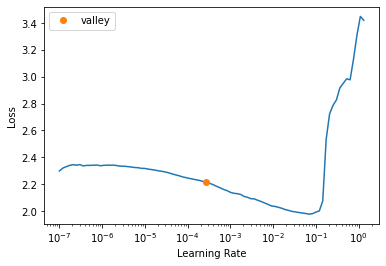

In [38]:
@patch_to(main_train)
def fit(learn,fit_type,epochs,freeze_epochs,initial_weights):
    """We can patch in a modification, e.g. if we want subtype of fine_tune:supervised_pretrain to be different
    to fine_tune:bt_pretrain"""

    if fit_type == 'encoder_fine_tune': #i.e. barlow twins

        learn.encoder_fine_tune(epochs,freeze_epochs=freeze_epochs) 

    elif fit_type == 'fine_tune':
        
        #elif initial_weights == 'supervised_pretrain':
        lrs = learn.lr_find()
        print(lrs.valley)
        learn.fit_one_cycle(epochs,lr_max=lrs.valley)
        #learn.no_freeze_linear_fine_tune(epochs,freeze_epochs=freeze_epochs) 

    else: raise Exception('Fit policy not of expected form')


initial_weights='no_pretrain'
pretrain=False
num_epochs='na'
numfit=50
freeze_num_epochs='na'
freeze_numfit=1 #even though we aren't actually freezing
main = main_train(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
        aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
        initial_weights=initial_weights,pretrain=pretrain,
        num_epochs=num_epochs,numfit=numfit,freeze_num_epochs=freeze_num_epochs,freeze_numfit=freeze_numfit,
        print_report=True,
                )

metrics = main.fine_tune()

## Ok, there is a subtlty with pretraining vs not: when pretraining we freeze the head, and when not, we don't. So we have to edit `fine_tune` within `main_train` so there is a bit more flexibility:

## Ok, so `fit_one_cycle` works the best! So let's patch it back in. Also, just need to add `pretrain` argument to `fine_tune`

In [9]:
@patch_to(main_train)
def fit(learn,fit_type,epochs,freeze_epochs,initial_weights,pretrain):
    """We can patch in a modification, e.g. if we want subtype of fine_tune:supervised_pretrain to be different
    to fine_tune:bt_pretrain"""

    if fit_type == 'encoder_fine_tune': #i.e. barlow twins

        #learn.encoder_fine_tune(epochs,freeze_epochs=freeze_epochs)
        lr_max=0.0030199517495930195
        print(f'lr_max={lr_max}')
        learn.fit_one_cycle(epochs,lr_max= lr_max)

    elif fit_type == 'fine_tune':

        if pretrain == False:
            print('pretrain was False, and about to fit_one_cycle')
            learn.fit_one_cycle(epochs,lr_max=0.00027542) 

        elif pretrain == True:
            print('pretrain was True, and about to linear_fine_tune')
            learn.linear_fine_tune(epochs,freeze_epochs=freeze_epochs) #This gave very similar performance, when pretrain=False (see above)

        #learn.no_freeze_linear_fine_tune(epochs,freeze_epochs=freeze_epochs) 

    else: raise Exception('Fit policy not of expected form')


@patch
def fine_tune(self:main_train):
    "fine tune in supervised fashion, according to tune_fit_policy, and get metrics"


    #encoder = pickle.loads(pickle.dumps(self.encoder)) #We might want to pretrain once and fine tune several times (varying e.g. tune augs)

    try: 
        encoder = self.encoder
    
    except AttributeError:
        _,self.encoder = create_model(which_model=self.initial_weights,ps=self.ps,device=self.device)

    model = LM(self.encoder)
    learn = Learner(self.dls_tune,model,splitter=my_splitter,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)

    #debugging
    #learn = Learner(self.dls_tune,model,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)

    main_train.fit(learn,fit_type='fine_tune',
                    epochs=self.numfit,freeze_epochs=self.freeze_numfit,
                    initial_weights=self.initial_weights,
                    pretrain=self.pretrain
                    ) #fine tuning (don't confuse this with fit policy!)
    scores,preds, acc = predict_model(self.xval,self.yval,model=model,aug_pipelines_test=self.aug_pipelines_test,numavg=3)
    #metrics dict will have f1 score, auc etc etc
    metrics = classification_report_wrapper(preds, self.yval, self.vocab, print_report=self.print_report)
    auc_dict = plot_roc(self.yval,preds,self.vocab,print_plot=self.print_plot)
    metrics['acc'],metrics['auc_dict'],metrics['scores'],metrics['preds'],metrics['xval'],metrics['yval'] = acc,auc_dict,scores,preds,self.xval,self.yval

    #torch.save(model.state_dict(), self.tuned_model_path)
    return metrics #


@patch
def train_encoder(self:main_train):
    "create encoder and (optionally, if pretrain=True) train with BT algorithm, according to fit_policy"

    try: #get existing encoder and plonk on new projector
        encoder = self.encoder
        encoder.cpu()
        bt_model = create_barlow_twins_model(encoder, hidden_size=self.ps,projection_size=self.ps,nlayers=3)
        bt_model.cuda()

    except AttributeError: #otherwise, create
        bt_model,encoder = create_model(which_model=self.initial_weights,ps=self.ps,device=self.device)

    if self.pretrain: #train encoder according to fit policy

        #lmb=0.005
        lmb=1/8192
        print(f'lmb={lmb}')
        learn = Learner(self.dls_train,bt_model,splitter=my_splitter_bt,cbs=[BarlowTwins(self.aug_pipelines,n_in=self.n_in,lmb=lmb,print_augs=False)])
        main_train.fit(learn,fit_type='encoder_fine_tune',
                        epochs=self.num_epochs,freeze_epochs=self.freeze_num_epochs,
                        initial_weights=self.initial_weights,
                        pretrain=self.pretrain
                        )
        
    self.encoder = bt_model.encoder

## Note: using the old `encoder_fine_tune` (see above: the one we used for pretrained initial weights) didn't seem to work here. What do I mean by that: well one run gave mid performace; and when changed lmb from 1/8192 to the lmb from the paper, the loss was barely even going down! Something to mildly explore tomorrow perhaps is effect of lmb.

lmb=0.0001220703125


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


0.0030199517495930195


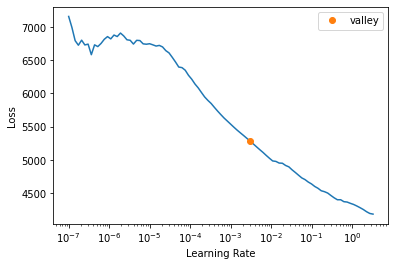

In [8]:
bt_model,encoder = create_model(which_model='no_pretrain',ps=8192,device=device)

lmb=1/8192
print(f'lmb={lmb}')
learn = Learner(dls_train,bt_model,splitter=my_splitter_bt,cbs=[BarlowTwins(aug_pipelines,n_in=3,lmb=lmb,print_augs=False)])
lrs = learn.lr_find()
print(lrs.valley)

In [ ]:
assert False

## Experiment: with random initial weights, we run several times with pretrain=True and pretrain=False, and record results to ensemble as well. The hope is that pretraining helps, and that ensembling also helps. If so, we can potentially implement our ensemble decorrelation idea as well

In [10]:
def run_main_train(pretrain,initial_weights='no_pretrain',num_epochs=300,freeze_num_epochs=1,freeze_numfit=6,numfit=75,num=5):
    "run main_train num times."

    main_dict = {}
    for i in range(num):

        main = main_train(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
                aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
                initial_weights=initial_weights,pretrain=pretrain,
                num_epochs=num_epochs,numfit=numfit,freeze_num_epochs=freeze_num_epochs,freeze_numfit=freeze_numfit,
                print_report=True,
                        )
        
        metrics = main()
        main_dict[i] = metrics

    return main_dict
        

In [17]:
#results = load_dict_from_gdrive('random_weights_baseline')

FileNotFoundError: ignored

## Results here for `False` but didn't save unfortunately:

In [48]:
#lst = [False,True] #pretrain or not
#results={False:None,True:None} 

# for pretrain in lst:
#     main_dict = run_main_train(pretrain=pretrain,num=5)
#     results[pretrain] = main_dict #main_dict has result of running main num=3 times.

# save_dict_to_gdrive('results','random_weights_baseline')

pretrain was False, and about to fit_one_cycle


epoch,train_loss,valid_loss,time
0,2.406166,None,00:06
1,2.344286,None,00:06
2,2.302051,None,00:07
3,2.274749,None,00:06
4,2.243268,None,00:06
5,2.209291,None,00:06
6,2.186220,None,00:06
7,2.171994,None,00:06
8,2.156175,None,00:06
9,2.140871,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


                            precision    recall  f1-score   support

         actinic keratosis       0.40      0.60      0.48        20
      basal cell carcinoma       0.59      0.50      0.54        20
            dermatofibroma       0.56      0.53      0.54        19
                  melanoma       0.38      0.25      0.30        20
                     nevus       0.63      0.60      0.62        20
pigmented benign keratosis       0.59      0.65      0.62        20
      seborrheic keratosis       0.40      0.40      0.40        15
   squamous cell carcinoma       0.32      0.30      0.31        20
           vascular lesion       0.76      0.80      0.78        20

                  accuracy                           0.52       174
                 macro avg       0.51      0.51      0.51       174
              weighted avg       0.52      0.52      0.51       174

pretrain was False, and about to fit_one_cycle


epoch,train_loss,valid_loss,time
0,2.384383,None,00:06
1,2.378602,None,00:06
2,2.332768,None,00:06
3,2.296322,None,00:06
4,2.261549,None,00:06
5,2.228767,None,00:06
6,2.201379,None,00:06
7,2.180443,None,00:07
8,2.163345,None,00:06
9,2.146650,None,00:07


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


                            precision    recall  f1-score   support

         actinic keratosis       0.40      0.50      0.44        20
      basal cell carcinoma       0.43      0.30      0.35        20
            dermatofibroma       0.63      0.63      0.63        19
                  melanoma       0.46      0.30      0.36        20
                     nevus       0.56      0.50      0.53        20
pigmented benign keratosis       0.47      0.70      0.56        20
      seborrheic keratosis       0.53      0.53      0.53        15
   squamous cell carcinoma       0.37      0.35      0.36        20
           vascular lesion       0.71      0.75      0.73        20

                  accuracy                           0.51       174
                 macro avg       0.51      0.51      0.50       174
              weighted avg       0.51      0.51      0.50       174

pretrain was False, and about to fit_one_cycle


epoch,train_loss,valid_loss,time
0,2.318377,None,00:06
1,2.290640,None,00:06
2,2.252037,None,00:07
3,2.226656,None,00:06
4,2.207845,None,00:06
5,2.192551,None,00:06
6,2.175910,None,00:06
7,2.157267,None,00:07
8,2.143090,None,00:06
9,2.125421,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


                            precision    recall  f1-score   support

         actinic keratosis       0.46      0.55      0.50        20
      basal cell carcinoma       0.50      0.40      0.44        20
            dermatofibroma       0.42      0.53      0.47        19
                  melanoma       0.50      0.40      0.44        20
                     nevus       0.61      0.55      0.58        20
pigmented benign keratosis       0.42      0.50      0.45        20
      seborrheic keratosis       0.47      0.47      0.47        15
   squamous cell carcinoma       0.35      0.35      0.35        20
           vascular lesion       0.88      0.75      0.81        20

                  accuracy                           0.50       174
                 macro avg       0.51      0.50      0.50       174
              weighted avg       0.51      0.50      0.50       174

pretrain was False, and about to fit_one_cycle


epoch,train_loss,valid_loss,time
0,2.324202,None,00:06
1,2.310801,None,00:06
2,2.293160,None,00:06
3,2.269609,None,00:06
4,2.242237,None,00:07
5,2.222595,None,00:07
6,2.198512,None,00:06
7,2.183480,None,00:06
8,2.165242,None,00:06
9,2.145864,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


                            precision    recall  f1-score   support

         actinic keratosis       0.37      0.50      0.43        20
      basal cell carcinoma       0.37      0.35      0.36        20
            dermatofibroma       0.37      0.37      0.37        19
                  melanoma       0.42      0.40      0.41        20
                     nevus       0.73      0.55      0.63        20
pigmented benign keratosis       0.46      0.65      0.54        20
      seborrheic keratosis       0.62      0.53      0.57        15
   squamous cell carcinoma       0.25      0.20      0.22        20
           vascular lesion       0.78      0.70      0.74        20

                  accuracy                           0.47       174
                 macro avg       0.49      0.47      0.47       174
              weighted avg       0.48      0.47      0.47       174

pretrain was False, and about to fit_one_cycle


epoch,train_loss,valid_loss,time
0,2.471555,None,00:07
1,2.425272,None,00:06
2,2.388667,None,00:07
3,2.352469,None,00:06
4,2.327425,None,00:06
5,2.297938,None,00:07
6,2.266333,None,00:07
7,2.238332,None,00:07
8,2.218767,None,00:06
9,2.197657,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


                            precision    recall  f1-score   support

         actinic keratosis       0.48      0.55      0.51        20
      basal cell carcinoma       0.56      0.50      0.53        20
            dermatofibroma       0.50      0.58      0.54        19
                  melanoma       0.30      0.35      0.33        20
                     nevus       0.69      0.45      0.55        20
pigmented benign keratosis       0.50      0.60      0.55        20
      seborrheic keratosis       0.22      0.13      0.17        15
   squamous cell carcinoma       0.38      0.40      0.39        20
           vascular lesion       0.81      0.85      0.83        20

                  accuracy                           0.50       174
                 macro avg       0.49      0.49      0.49       174
              weighted avg       0.50      0.50      0.50       174



TypeError: ignored

Find good learning rate for BT:

In [11]:
lst = [True] #pretrain or not
results={False:None,True:None} 

for pretrain in lst:
    main_dict = run_main_train(pretrain=pretrain,num=5)
    results[pretrain] = main_dict #main_dict has result of running main num=3 times.

save_dict_to_gdrive('results','random_weights_baseline')

lmb=0.0001220703125
lr_max=0.0030199517495930195


epoch,train_loss,valid_loss,time
0,6009.480469,None,00:06
1,5482.403809,None,00:06
2,5095.854980,None,00:07
3,4882.710938,None,00:07
4,4992.558105,None,00:06
5,5001.278809,None,00:07
6,4935.476562,None,00:07
7,4814.219727,None,00:07
8,4700.247070,None,00:07
9,4603.010254,None,00:06


pretrain was True, and about to linear_fine_tune


epoch,train_loss,valid_loss,time
0,2.462894,None,00:06
1,2.385900,None,00:06
2,2.320800,None,00:06
3,2.246153,None,00:07
4,2.208275,None,00:06
5,2.176217,None,00:07


epoch,train_loss,valid_loss,time
0,1.943379,None,00:06
1,1.897892,None,00:06
2,1.847654,None,00:06
3,1.802487,None,00:06
4,1.748927,None,00:07
5,1.707344,None,00:06
6,1.654980,None,00:07
7,1.611318,None,00:07
8,1.577233,None,00:06
9,1.536654,None,00:06


                            precision    recall  f1-score   support

         actinic keratosis       0.38      0.45      0.41        20
      basal cell carcinoma       0.64      0.45      0.53        20
            dermatofibroma       0.60      0.63      0.62        19
                  melanoma       0.30      0.30      0.30        20
                     nevus       0.67      0.40      0.50        20
pigmented benign keratosis       0.50      0.65      0.57        20
      seborrheic keratosis       0.27      0.27      0.27        15
   squamous cell carcinoma       0.32      0.35      0.33        20
           vascular lesion       0.90      0.95      0.93        20

                  accuracy                           0.50       174
                 macro avg       0.51      0.49      0.49       174
              weighted avg       0.51      0.50      0.50       174

lmb=0.0001220703125
lr_max=0.0030199517495930195


epoch,train_loss,valid_loss,time
0,6747.148926,None,00:07
1,5940.938965,None,00:06
2,5502.279785,None,00:07
3,5138.750000,None,00:06
4,4947.029785,None,00:06
5,4789.472656,None,00:07
6,4664.487305,None,00:06
7,4562.897461,None,00:06
8,4487.767090,None,00:06
9,4392.306152,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


pretrain was True, and about to linear_fine_tune


epoch,train_loss,valid_loss,time
0,2.585106,None,00:06
1,2.438113,None,00:06
2,2.346063,None,00:06
3,2.310841,None,00:06
4,2.291074,None,00:06
5,2.250236,None,00:07


epoch,train_loss,valid_loss,time
0,2.042767,None,00:06
1,1.927892,None,00:06
2,1.883211,None,00:06
3,1.823384,None,00:06
4,1.770727,None,00:06
5,1.717298,None,00:06
6,1.666942,None,00:06
7,1.622780,None,00:06
8,1.577195,None,00:06
9,1.532462,None,00:06


                            precision    recall  f1-score   support

         actinic keratosis       0.45      0.50      0.48        20
      basal cell carcinoma       0.61      0.55      0.58        20
            dermatofibroma       0.56      0.74      0.64        19
                  melanoma       0.31      0.20      0.24        20
                     nevus       0.59      0.50      0.54        20
pigmented benign keratosis       0.48      0.65      0.55        20
      seborrheic keratosis       0.35      0.40      0.38        15
   squamous cell carcinoma       0.47      0.40      0.43        20
           vascular lesion       0.89      0.80      0.84        20

                  accuracy                           0.53       174
                 macro avg       0.52      0.53      0.52       174
              weighted avg       0.53      0.53      0.52       174

lmb=0.0001220703125
lr_max=0.0030199517495930195


epoch,train_loss,valid_loss,time
0,6552.393555,None,00:07
1,6127.955566,None,00:07
2,5441.642090,None,00:07
3,5100.202637,None,00:07
4,4877.223145,None,00:07
5,4845.037598,None,00:07
6,4786.378418,None,00:07
7,4673.340820,None,00:07
8,4598.618652,None,00:07
9,4536.554199,None,00:07


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


pretrain was True, and about to linear_fine_tune


epoch,train_loss,valid_loss,time
0,2.533772,None,00:06
1,2.419952,None,00:06
2,2.347793,None,00:06
3,2.301937,None,00:06
4,2.266831,None,00:06
5,2.233668,None,00:06


epoch,train_loss,valid_loss,time
0,2.031568,None,00:06
1,1.947596,None,00:06
2,1.897066,None,00:06
3,1.838889,None,00:06
4,1.791621,None,00:06
5,1.736595,None,00:07
6,1.688007,None,00:06
7,1.642757,None,00:06
8,1.604764,None,00:07
9,1.559552,None,00:06


                            precision    recall  f1-score   support

         actinic keratosis       0.46      0.65      0.54        20
      basal cell carcinoma       0.73      0.40      0.52        20
            dermatofibroma       0.65      0.68      0.67        19
                  melanoma       0.35      0.30      0.32        20
                     nevus       0.69      0.45      0.55        20
pigmented benign keratosis       0.54      0.65      0.59        20
      seborrheic keratosis       0.41      0.47      0.44        15
   squamous cell carcinoma       0.55      0.60      0.57        20
           vascular lesion       0.86      0.95      0.90        20

                  accuracy                           0.57       174
                 macro avg       0.58      0.57      0.57       174
              weighted avg       0.59      0.57      0.57       174

lmb=0.0001220703125
lr_max=0.0030199517495930195


epoch,train_loss,valid_loss,time
0,6404.328613,None,00:07
1,5784.011719,None,00:07
2,5354.826660,None,00:07
3,5285.333984,None,00:06
4,5035.754883,None,00:07
5,4859.652832,None,00:07
6,4731.025391,None,00:07
7,4637.437500,None,00:07
8,4565.393555,None,00:07
9,4494.444824,None,00:07


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


pretrain was True, and about to linear_fine_tune


epoch,train_loss,valid_loss,time
0,2.378639,None,00:07
1,2.314487,None,00:06
2,2.266733,None,00:07
3,2.200121,None,00:07
4,2.162762,None,00:07
5,2.150892,None,00:06


epoch,train_loss,valid_loss,time
0,2.053690,None,00:07
1,1.949391,None,00:07
2,1.874760,None,00:07
3,1.826077,None,00:07
4,1.775553,None,00:07
5,1.717690,None,00:07
6,1.666742,None,00:07
7,1.622536,None,00:07
8,1.579679,None,00:07
9,1.537731,None,00:07


                            precision    recall  f1-score   support

         actinic keratosis       0.38      0.55      0.45        20
      basal cell carcinoma       0.65      0.55      0.59        20
            dermatofibroma       0.70      0.74      0.72        19
                  melanoma       0.44      0.40      0.42        20
                     nevus       0.62      0.40      0.48        20
pigmented benign keratosis       0.54      0.70      0.61        20
      seborrheic keratosis       0.47      0.53      0.50        15
   squamous cell carcinoma       0.50      0.40      0.44        20
           vascular lesion       0.94      0.85      0.89        20

                  accuracy                           0.57       174
                 macro avg       0.58      0.57      0.57       174
              weighted avg       0.58      0.57      0.57       174

lmb=0.0001220703125
lr_max=0.0030199517495930195


epoch,train_loss,valid_loss,time
0,6977.709961,None,00:08
1,6159.471680,None,00:08
2,5640.330566,None,00:07
3,5319.817383,None,00:08
4,5117.714355,None,00:07
5,4928.233887,None,00:07
6,4781.720703,None,00:07
7,4684.546875,None,00:08
8,4597.595703,None,00:07
9,4518.956055,None,00:08


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


pretrain was True, and about to linear_fine_tune


epoch,train_loss,valid_loss,time
0,2.358348,None,00:07
1,2.294590,None,00:07
2,2.252769,None,00:07
3,2.189398,None,00:07
4,2.158870,None,00:07
5,2.158762,None,00:07


epoch,train_loss,valid_loss,time
0,1.984726,None,00:07
1,1.946343,None,00:07
2,1.889562,None,00:07
3,1.844278,None,00:07
4,1.796009,None,00:07
5,1.741777,None,00:07
6,1.697307,None,00:07
7,1.656104,None,00:07
8,1.615751,None,00:07
9,1.579463,None,00:08


                            precision    recall  f1-score   support

         actinic keratosis       0.50      0.70      0.58        20
      basal cell carcinoma       0.67      0.50      0.57        20
            dermatofibroma       0.58      0.79      0.67        19
                  melanoma       0.25      0.20      0.22        20
                     nevus       0.57      0.40      0.47        20
pigmented benign keratosis       0.45      0.50      0.48        20
      seborrheic keratosis       0.31      0.33      0.32        15
   squamous cell carcinoma       0.65      0.55      0.59        20
           vascular lesion       0.90      0.90      0.90        20

                  accuracy                           0.55       174
                 macro avg       0.54      0.54      0.53       174
              weighted avg       0.55      0.55      0.54       174



#Print out result of each run and save: 

In [ ]:
from statistics import mean,stdev
print('random initial weights: ')
for pretrain in lst:

    _results = [results[pretrain][i]['acc'] for i in range(len(results[pretrain]))]

    print(f"\npretrain={pretrain}, results are: {_results}")
    print(f"mean is: {mean(_results)}\n")
    #print(f"std is: {stdev(_results)}")


In [ ]:
#save_dict_to_gdrive(results,'base_results')

In [ ]:
from itertools import combinations

print('Ensembling within type of initial weights')

def within_ensemble_results(results,key,param='pretrain'):

    print(f'Results for {param}={key}')

    _results = list(results[key].values())
    _results = list(combinations(_results,2)) #all pairs of results. So for num=3, will be 3
    for v in _results:

        print(f"\nAcc of first guy in ensemble is: {v[0]['acc']}")
        print(f"Acc of second guy in ensemble is: {v[1]['acc']}")
        _,acc = predict_ensemble(yval=yval,scores1=v[0]['scores'],scores2=v[1]['scores'])
        print(f'Acc of ensemble is:{acc}\n')

In [ ]:
within_ensemble_results(results,key=True)

In [57]:
#within_ensemble_results(results,key=False)

In [ ]:
import itertools
print('Ensembling between')

def between_ensemble_results(results,key1,key2,param='pretrain'):

    _results = list(itertools.product(results[key1].values(),results[key2].values()))

    for v in _results:

        print(f"\nAcc of first guy in ensemble ({key1}) is: {v[0]['acc']}")
        print(f"Acc of second guy in ensemble ({key2}) is: {v[1]['acc']}")
        _,acc = predict_ensemble(yval=yval,scores1=v[0]['scores'],scores2=v[1]['scores'])
        print(f'Acc of ensemble is:{acc}\n')


 

Between ensemble doesn't matter as much here: i.e. between is between pretrain=True and pretrain=False

In [ ]:
between_ensemble_results(results,key1=True,key2=False)

In [ ]:
#| hide

# #old supervised baseline (with fine tune)

# tem = {0: 0.6724137663841248,
#  1: 0.7126436829566956,
#  2: 0.6724137663841248,
#  3: 0.6321839094161987,
#  4: 0.6896551847457886}

# from statistics import mean
# mean(list(tem.values()))